# A game of tag

To exemplify the use of the Road Agent framework we shall write a game
of tag simulation.

Agents are bike riders. Tagged bikes -which are faster- seek untagged
riders. If they come close enough to untagged bikes, they tag them! To increase
their chances of catching untagged bikes, they randomly circle nodes with the
**highest** [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality)
in the street network.

Untagged riders must cross town from point A to point B and back again
continuously. As an evasive strategy untagged bikes route through points with the **lowest** 
[betweeness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) in
the street network.

## The environment

Agent Based simulations usually involve interaction with the
environment. We shall use the [OSMNX](https://pypi.org/project/OSMnx/)
library to download a street network, and use nodes from it to 
set points and destinations for agents.

In [1]:
import osmnx as ox
%matplotlib inline
import matplotlib.pyplot as plt
ox.config(log_file=True, log_console=True, use_cache=True)
from LatLon23 import LatLon

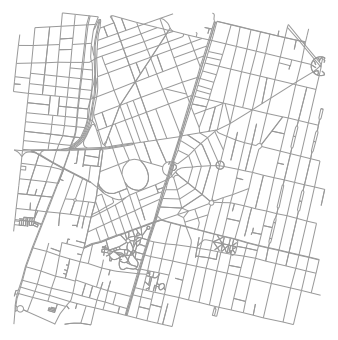

In [2]:
# grab a square somewhere in Mexico City
G = ox.graph_from_point((19.3838,-99.1758), distance=1200)
fig, ax = ox.plot_graph(G, node_size=0)

# you could also use this method and run a simulation on your home town. Try it!
#G = ox.graph_from_place('Tzintzuntzan, Michoacan, Mexico', network_type='bike')

## Set bases A and B 

Untagged bikes will run among these, to and fro.

In [3]:
# find westernmost node to make it base A
x_min = min([G.nodes[osmid]['x'] for osmid in G.nodes])
base_A = [G.nodes[osmid] for osmid in G.nodes if G.nodes[osmid]['x'] == x_min][0]
base_A_point = LatLon(base_A['y'], base_A['x'])
base_A

{'y': 19.3891887, 'x': -99.1872013, 'osmid': 274925216}

In [4]:
# find easternmost node to make it base B
x_max = max([G.nodes[osmid]['x'] for osmid in G.nodes])
base_B = [G.nodes[osmid] for osmid in G.nodes if G.nodes[osmid]['x'] == x_max][0]
base_B_point = LatLon(base_B['y'], base_B['x'])
base_B

{'y': 19.3915153, 'x': -99.1643852, 'osmid': 4074023177}

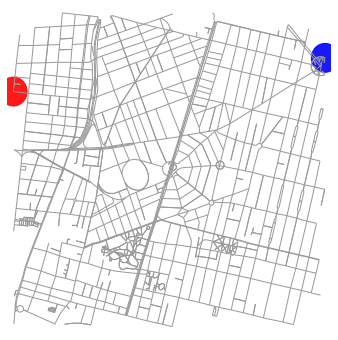

In [5]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.add_artist(plt.Circle((base_A['x'], base_A['y']), 0.001, color='red', alpha=0.9))
ax.add_artist(plt.Circle((base_B['x'], base_B['y']), 0.001, color='blue', alpha=0.9))

plt.show()

## Low betweenness centrality nodes

Crate a list of low betweenness centrality nodes. We'll grab items from here to include in the untagged routes, according to our evasion strategy.

In [6]:
lower_betweeness_threshold = 0.004

import networkx as nx
import random
import numpy as np

centrality = ox.extended_stats(G)['degree_centrality']

low_btw = [LatLon(G.nodes[osmid]['y'], G.nodes[osmid]['x']) 
           for osmid in centrality
           if centrality[osmid] > 0 and centrality[osmid] <= lower_betweeness_threshold]

print(len(low_btw), "low betweenness nodes, out of a total of ", len(G.nodes))

# a random node from this dict
random.choice(low_btw)

789 low betweenness nodes, out of a total of  1080


Latitude 19.3847226, Longitude -99.1661743

## High betweeness centrality nodes

Tagged agents will roam the most central nodes. Victims are shure to come by!

In [7]:
high_betweeness_threshold = 0.007

high_btw = [LatLon(G.nodes[osmid]['y'], G.nodes[osmid]['x']) 
            for osmid in centrality
            if centrality[osmid] >= high_betweeness_threshold]

# there's just a few of them
high_btw

[Latitude 19.3852033, Longitude -99.1807593,
 Latitude 19.3802758, Longitude -99.186456,
 Latitude 19.3802572, Longitude -99.1862898,
 Latitude 19.3757422, Longitude -99.1767416,
 Latitude 19.3898645, Longitude -99.1782751,
 Latitude 19.3819739, Longitude -99.1851678,
 Latitude 19.3806848, Longitude -99.1767155,
 Latitude 19.3804975, Longitude -99.1767748,
 Latitude 19.3801415, Longitude -99.1768934,
 Latitude 19.3828092, Longitude -99.1760359,
 Latitude 19.3775031, Longitude -99.1788006,
 Latitude 19.3777726, Longitude -99.1793615,
 Latitude 19.3778599, Longitude -99.1790525,
 Latitude 19.377877, Longitude -99.178673,
 Latitude 19.3779294, Longitude -99.178475,
 Latitude 19.3779269, Longitude -99.1801769,
 Latitude 19.3780762, Longitude -99.1785769,
 Latitude 19.3780832, Longitude -99.1805501,
 Latitude 19.3781394, Longitude -99.1799033,
 Latitude 19.3781933, Longitude -99.178272,
 Latitude 19.3782312, Longitude -99.1784476,
 Latitude 19.378258, Longitude -99.1802227,
 Latitude 19.378

## The Bike class

Now we extend the Agent class to create our bikes. We'll write methods for both modes of play: tagged and untagged.


In [8]:
from road_agent import Agent

class Bike(Agent):

    def dest_high_btw_node(self):
        """
        tagged agents will ride to high betweenness nodes
        to increase their chances of catching untagged agents
        """
        self.set_destination(random.choice(high_btw))
        self.update_route()
    
    def set_mode(self, mode):
        if mode == 'tagged':
            self.mode = 't'
            # tagged bikes go faster
            self.speed = random.uniform(4, 6)  # speed given in m/s
            # just got tagged? select random destination
            self.dest_high_btw_node()
        else:
            self.mode = 'u'
            self.speed = random.uniform(3, 4)
            # choose a route through low betweeness node
            b.update_route([random.choice(low_btw), ])
            
    def tag_nearby_agents(self, bikes):
        """
        seek bikes close to me, tag them!
        """
        for b in bikes:
            if self.distance_to(b.point()) < self.speed and b.mode == 'u':
                print("at t=%s agent %s tagged %s!" % (t, id(self), id(b)))
                b.set_mode('tagged')
                break  # tag just one at a time!

    def tagged_step(self):
        # Here we use the global variable N which contains the whole bike population
        # 'cause this is a tutorial and it is useful to keep it simple.
        # But you might use a database with useful queries and such
        # by mixing in the Agent class with an ORM
        self.tag_nearby_agents(N)

        # choose a destination
        if self.got_there():
            self.dest_high_btw_node()
        else:
            self.step()
        
    def untagged_step(self):
        if self.got_there():
            # got to a base? turn around and head back to the one you came from!
            if self.destination() == base_A_point:
                self.set_destination(base_B_point)
            elif self.destination() == base_B_point:
                self.set_destination(base_A_point)
            
            # but go through a low betweenness centrality node, to try and evade taggers
            self.update_route([random.choice(low_btw), ])
        else:
            self.step()
    
    def play_tag(self):
        if self.mode == 't':
            self.tagged_step()
        elif self.mode == 'u':
            self.untagged_step()    

### Initialize NXRouter

The Road Agent framework is distributed with two router alternatives:
 1. NXRouter, wich uses shortest paths computed with the NetworkX library.
 2. BRouter wich uses a BRouter server to query routes.
 
NXRouter is simpler but easier to run. Some directed graphs will fail to find paths between nodes. BRouter is very thorough but it requires the installation and running of the BRouter server which is a java program and maybe a long download.

Here we shall use the NXRouter. To keep it simple, we convert the directed street network to an undirected one, which makes all streets run both ways, but makes it easy to route from any point in the graph to any other point.

In [9]:
from road_agent.router import NXRouter

undirected_G = nx.to_undirected(G)

# NXRouter is initialized with a graph
router = NXRouter(undirected_G)

### Simulation initialization

In [10]:
number_of_bikes = 20
simulation_steps = 2400

# log population sizes
tagged_pop = np.zeros(simulation_steps)
untagged_pop = np.zeros(simulation_steps)

# create a bike population with a list comprehension
N = [Bike(point=base_A_point, dest=base_B_point,  # all bikes start at base A, heading for B
          router=router)
     for n in range(number_of_bikes)]

for b in N:
    # set them all in the untagged mode
    b.set_mode('untagged')
    # let each agent keep a log of its trail
    b.trail = []
    
# create one tagged bike!
point, dest = random.sample(high_btw, 2)
tagged_bike = Bike(point=point, dest=dest, router=router)
tagged_bike.set_mode('tagged')
tagged_bike.trail = []

# add it to the total bike population
N.append(tagged_bike)

### Run simulation

In [11]:
for t in range(simulation_steps):
    # update population logs
    tagged_pop[t] = len([1 for b in N if b.mode == 't'])
    untagged_pop[t] = len([1 for b in N if b.mode == 'u'])

    for b in N:
        b.play_tag()
        # make a log entry every 100 steps
        if t % 100 == 0:
            b.trail.append({'point': (float(b.point().to_string()[1]),
                                      float(b.point().to_string()[0])),
                            'mode': b.mode})

### Plot population dynamics

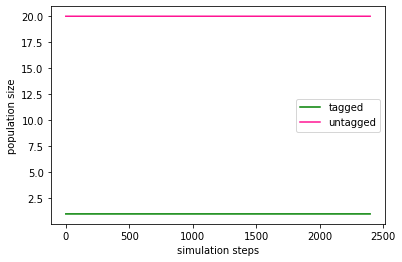

In [12]:
fig = plt.figure()
ax = fig.gca()
plt.plot(range(simulation_steps), tagged_pop, color='green', label='tagged')
plt.plot(range(simulation_steps), untagged_pop, color='deeppink', label='untagged')
ax.set_ylabel('population size')
ax.set_xlabel('simulation steps')
ax.legend()
plt.show()

### Plot some frames

Tagged agents are green, untagged agents are pink.

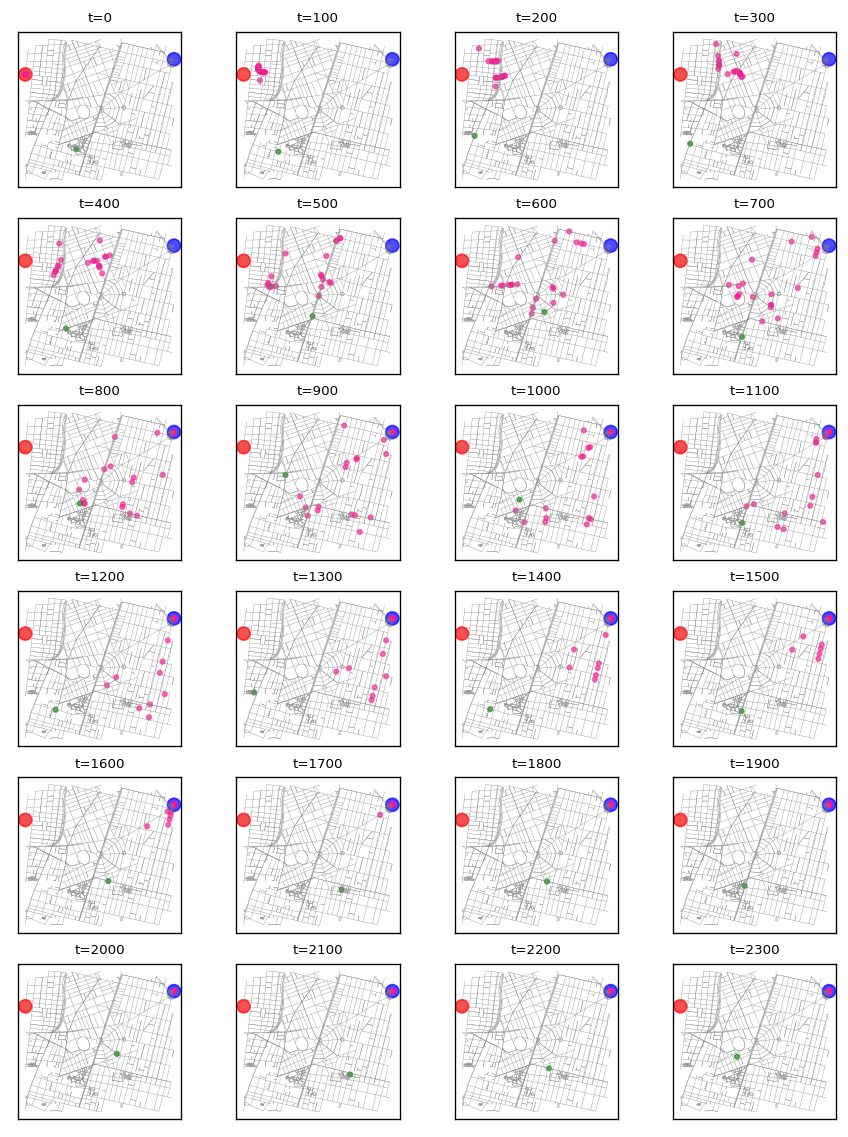

In [13]:
# get edges of street network into geodataframe, for easier re-use
gdf = ox.plot.graph_to_gdfs(G, nodes=False)

fig, axes = plt.subplots(nrows=6, ncols=4,
                         sharex='all', sharey='all',
                         figsize=(9, 12), dpi=120)

axes = axes.flat
for ax, t in zip(axes, range(24)):
    # plot streets
    gdf.plot(ax=ax, linewidth=0.2, color="grey")
    # mark bases
    ax.add_artist(plt.Circle((base_A['x'], base_A['y']), 0.001, color='red', alpha=0.7))
    ax.add_artist(plt.Circle((base_B['x'], base_B['y']), 0.001, color='blue', alpha=0.7))
    # mark agent locations at current timestep
    for b in N:
        if b.trail[t]['mode'] == 'u':
            color = 'deeppink'
        elif b.trail[t]['mode'] == 't':
            color = 'green'
        ax.add_artist(plt.Circle(b.trail[t]['point'], 0.00035, color=color, alpha=0.6))
    ax.set_title("t=%s" % (t*100), fontdict={'fontsize': 8})
    ax.set_xticks([]) 
    ax.set_yticks([]) 

plt.show()